In [4]:
import os
import sys
from collections import Counter
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import shutil
torch.backends.cudnn.deterministic = True

In [2]:
features_csv = "/kaggle/input/animals/train_features.csv"
labels_csv = "/kaggle/input/animals/train_labels.csv"
image_root = "/kaggle/input/animals/"  # where the train_features folder is
output_root = "/kaggle/working/sorted_train/"  # destination folders


In [5]:
features_df = pd.read_csv(features_csv)
labels_df = pd.read_csv(labels_csv)

df = pd.merge(features_df, labels_df, on="id")
# Create output root
os.makedirs(output_root, exist_ok=True)

# Class names from label columns
class_names = labels_df.columns[1:]  # skip 'id'

for idx, row in df.iterrows():
    image_path = os.path.join(image_root, row["filepath"])
    label_vector = row[class_names].values.astype(int)

    # Only one class label should be '1'
    class_idx = label_vector.argmax()
    class_name = class_names[class_idx]

    # Destination folder
    class_dir = os.path.join(output_root, class_name)
    os.makedirs(class_dir, exist_ok=True)

    # Destination path
    filename = os.path.basename(row["filepath"])
    dest_path = os.path.join(class_dir, filename)

    # Copy or move
    shutil.copy(image_path, dest_path)


In [6]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


In [7]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img
transform = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

In [8]:
dataset = datasets.ImageFolder(root=output_root, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [9]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean of each channel as a tensor, the standard deviation of each channel as a tensor
            formatted as a tuple (means[channels], std[channels])"""

    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5

    return mean, std

In [10]:
mean, std = get_mean_std(dataloader)

print(f"Mean: {mean}")
print(f"Standard deviation: {std}")

Computing mean and std:   0%|          | 0/516 [00:00<?, ?it/s]

Mean: tensor([0.4788, 0.4925, 0.4833])
Standard deviation: tensor([0.2542, 0.2471, 0.2502])


iinstead of wasting time use this
Mean: tensor([0.4788, 0.4925, 0.4833])
Standard deviation: tensor([0.2542, 0.2471, 0.2502])

In [11]:
transform_norm = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

In [13]:
norm_dataset =datasets.ImageFolder(root=output_root, transform=transform_norm)
norm_loader = DataLoader(norm_dataset, batch_size=32, shuffle=True)


In [14]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)

train_dataset, val_dataset = random_split(norm_dataset,[0.8,0.2])

length_train = len(train_dataset)
length_val = len(val_dataset)
length_dataset = len(norm_dataset)
percent_train = np.round(100 * length_train / length_dataset, 2)
percent_val = np.round(100 * length_val / length_dataset, 2)

print(f"Train data is {percent_train}% of full data")
print(f"Validation data is {percent_val}% of full data")

Train data is 80.0% of full data
Validation data is 20.0% of full data


In [15]:
def class_counts(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})

In [17]:
train_class_distributions = class_counts(train_dataset)
val_class_distributions = class_counts(val_dataset)

  0%|          | 0/13191 [00:00<?, ?it/s]

  0%|          | 0/3297 [00:00<?, ?it/s]

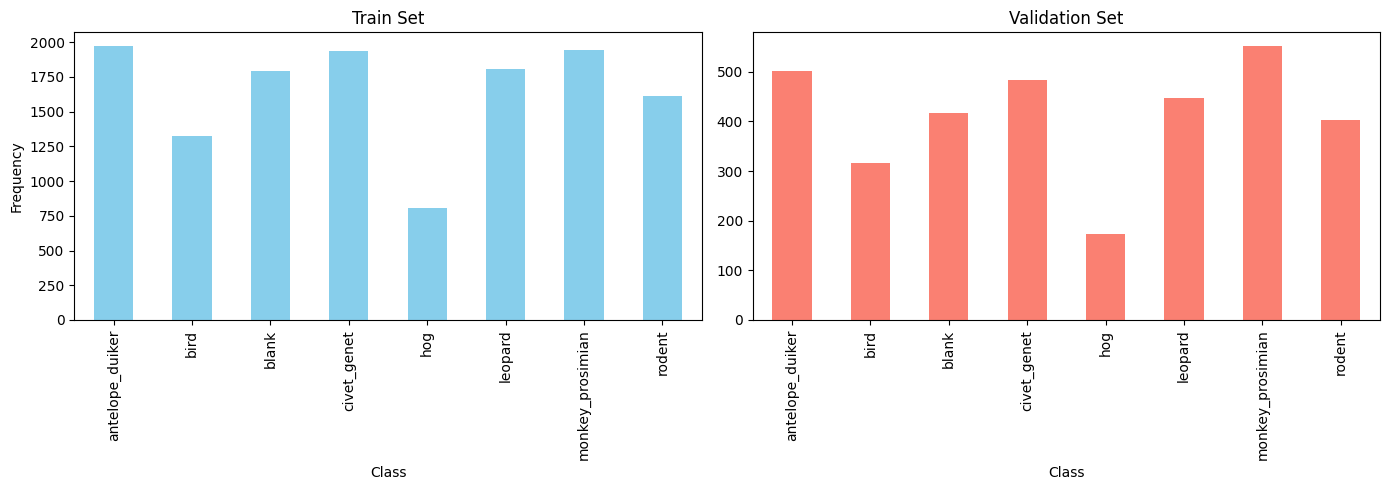

In [18]:
# Plot side-by-side
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

train_class_distributions.plot(kind='bar', ax=ax[0], color='skyblue', title="Train Set")
val_class_distributions.plot(kind='bar', ax=ax[1], color='salmon', title="Validation Set")

ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("Class")
ax[1].set_xlabel("Class")
plt.tight_layout()
plt.show()


In [19]:
# Important, don't change this!
g = torch.Generator()
g.manual_seed(42)


batch_size = 32

train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)

val_loader = DataLoader(val_dataset,batch_size=32,shuffle=True)

single_batch = next(iter(train_loader))[0]
print(f"Shape of one batch: {single_batch.shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])


In [20]:
# Important! Don't change this
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model = torch.nn.Sequential()

conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1)
max_pool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model.append(conv1)
model.append(torch.nn.ReLU())
model.append(max_pool1)

conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1)
max_pool2 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2)
model.append(conv2)
model.append(torch.nn.ReLU())
model.append(max_pool2)

conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
max_pool3 = torch.nn.MaxPool2d(2)
model.append(conv3)
model.append(torch.nn.ReLU())
model.append(max_pool3)

model.append(torch.nn.Flatten())
model.append(torch.nn.Dropout())

linear1 = torch.nn.Linear(in_features=50176, out_features=500)
model.append(linear1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

output_layer = torch.nn.Linear(500, 8)
model.append(output_layer)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=8, bias=True)
)

In [21]:
height, width = 224, 224
summary(model, input_size=(batch_size, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 8]                   --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 112, 112]        --
├─Conv2d: 1-4                            [32, 32, 112, 112]        4,640
├─ReLU: 1-5                              [32, 32, 112, 112]        --
├─MaxPool2d: 1-6                         [32, 32, 56, 56]          --
├─Conv2d: 1-7                            [32, 64, 56, 56]          18,496
├─ReLU: 1-8                              [32, 64, 56, 56]          --
├─MaxPool2d: 1-9                         [32, 64, 28, 28]          --
├─Flatten: 1-10                          [32, 50176]               --
├─Dropout: 1-11                          [32, 50176]               --
├─Linear: 1-12                           [32, 500]                 25,088,500

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=8, bias=True)
)

In [24]:
import torch
from tqdm.notebook import tqdm


def train_epoch(model, optimizer, loss_fn, data_loader, device="cpu"):
    # INSERT ...
    # REMOVE{
    training_loss = 0.0
    model.train()

    # Iterate over all batches in the training set to complete one epoch
    for inputs, targets in tqdm(data_loader, desc="Training", leave=False):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)

        output = model(inputs)
        loss = loss_fn(output, targets)

        loss.backward()
        optimizer.step()
        training_loss += loss.data.item() * inputs.size(0)

    return training_loss / len(data_loader.dataset)
    # REMOVE}


def predict(model, data_loader, device="cpu"):
    # INSERT ...
    # REMOVE{
    all_probs = torch.tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Predicting", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)
            probs = torch.nn.functional.softmax(output, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)

    return all_probs
    # REMOVE}


def score(model, data_loader, loss_fn, device="cpu"):
    # INSERT ...
    # REMOVE{
    total_loss = 0
    total_correct = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Scoring", leave=False):
            inputs = inputs.to(device)
            output = model(inputs)

            targets = targets.to(device)
            loss = loss_fn(output, targets)
            total_loss += loss.data.item() * inputs.size(0)

            correct = torch.eq(torch.argmax(output, dim=1), targets)
            total_correct += torch.sum(correct).item()
    average_loss = total_loss / len(data_loader.dataset)
    accuracy = total_correct / len(data_loader.dataset)
    return average_loss, accuracy
    # REMOVE}


def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    # INSERT ...
    # REMOVE{
    for epoch in range(1, epochs + 1):
        # Train one epoch
        training_loss = train_epoch(model, optimizer, loss_fn, train_loader, device)

        # Test on validation set
        validation_loss, validation_accuracy = score(model, val_loader, loss_fn, device)

        print(
            f"Epoch: {epoch}, Training Loss: {training_loss:.2f}, "
            f"Validation Loss: {validation_loss:.2f}, Validation accuracy = {validation_accuracy:.2f}"
        )

In [25]:
train(model,optimizer,loss_fn,train_loader,val_loader,epochs=20,device=device)

Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 1.53, Validation Loss: 1.14, Validation accuracy = 0.60


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 1.02, Validation Loss: 0.80, Validation accuracy = 0.73


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.80, Validation Loss: 0.71, Validation accuracy = 0.75


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.67, Validation Loss: 0.62, Validation accuracy = 0.78


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.59, Validation Loss: 0.56, Validation accuracy = 0.81


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 0.51, Validation Loss: 0.53, Validation accuracy = 0.82


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 0.45, Validation Loss: 0.53, Validation accuracy = 0.82


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 0.41, Validation Loss: 0.54, Validation accuracy = 0.83


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 9, Training Loss: 0.38, Validation Loss: 0.53, Validation accuracy = 0.84


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 10, Training Loss: 0.35, Validation Loss: 0.49, Validation accuracy = 0.85


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 11, Training Loss: 0.31, Validation Loss: 0.51, Validation accuracy = 0.85


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 12, Training Loss: 0.29, Validation Loss: 0.48, Validation accuracy = 0.85


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 13, Training Loss: 0.28, Validation Loss: 0.50, Validation accuracy = 0.85


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 14, Training Loss: 0.25, Validation Loss: 0.52, Validation accuracy = 0.86


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 15, Training Loss: 0.25, Validation Loss: 0.52, Validation accuracy = 0.86


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 16, Training Loss: 0.23, Validation Loss: 0.53, Validation accuracy = 0.85


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 17, Training Loss: 0.22, Validation Loss: 0.51, Validation accuracy = 0.86


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 18, Training Loss: 0.22, Validation Loss: 0.54, Validation accuracy = 0.85


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 19, Training Loss: 0.19, Validation Loss: 0.53, Validation accuracy = 0.86


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 20, Training Loss: 0.19, Validation Loss: 0.52, Validation accuracy = 0.86


In [31]:
probabilities = predict(model,val_loader,device)
predictions = torch.argmax(probabilities,dim=1)

Predicting:   0%|          | 0/104 [00:00<?, ?it/s]

In [32]:
targets = []

for _, labels in tqdm(val_loader):
    targets.extend(labels.tolist())

  0%|          | 0/104 [00:00<?, ?it/s]

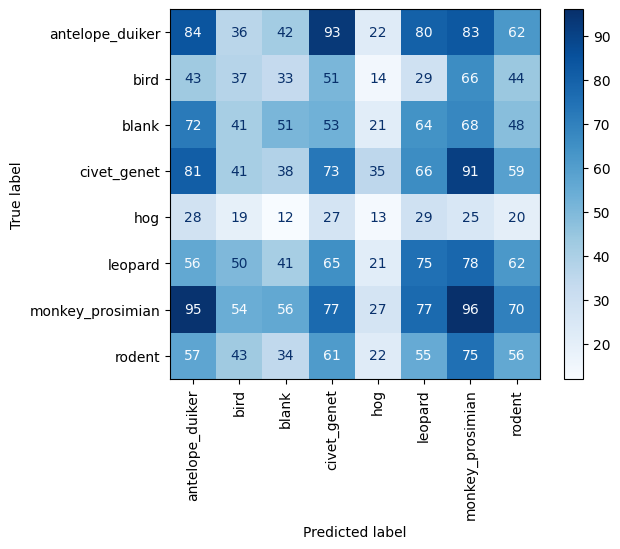

In [33]:

classes = norm_dataset.classes
cm = confusion_matrix(targets,predictions.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show();

In [34]:
test_features_df = pd.read_csv("/kaggle/input/animals/test_features.csv")

In [39]:
from torch.utils.data import Dataset, DataLoader
class TestImageDataset(Dataset):
    def __init__(self, dataframe, transform=None, root_dir="/kaggle/input/animals/"):
        self.df = dataframe
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root_dir, row["filepath"])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, row["id"]  # return ID for mapping predictions


In [40]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

test_dataset = TestImageDataset(test_features_df, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [41]:
probabilities = predict(model,test_loader,device)
predictions = torch.argmax(probabilities,dim=1)

Predicting:   0%|          | 0/140 [00:00<?, ?it/s]

In [46]:
# Reload test dataset to get (image, id) pairs
images, ids = [], []
for img, img_id in test_dataset:
    images.append(img)
    ids.append(img_id)

# Stack into a tensor
images = torch.stack(images)


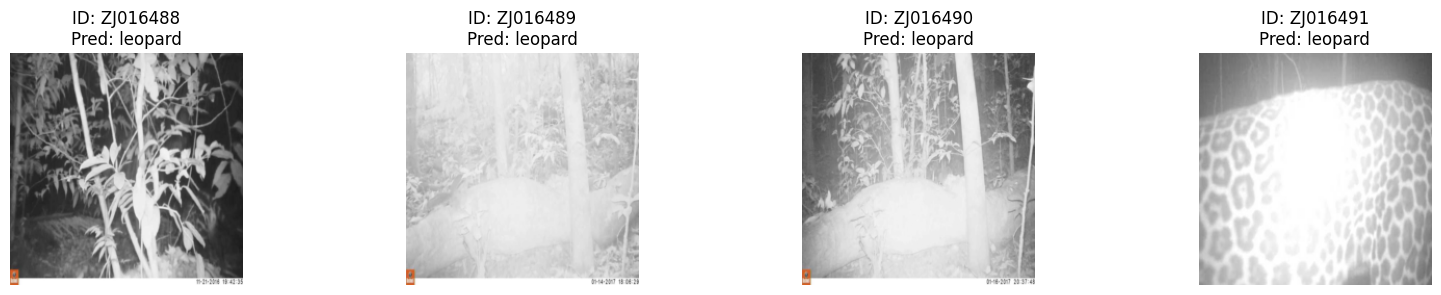

In [54]:
import matplotlib.pyplot as plt

# Get class names from training dataset
class_names = dataset.classes  # 'dataset' is your ImageFolder training dataset

# Number of images to display
N = 4

plt.figure(figsize=(16, 8))
for i in range(N):
    img = images[i].permute(1, 2, 0).numpy()  # CHW → HWC
    pred_class = class_names[predictions[i]]
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"ID: {ids[i]}\nPred: {pred_class}")
    plt.axis("off")

plt.tight_layout()
plt.show()
